In [78]:
from fastai.vision.all import load_learner, PILImage
from tqdm.notebook import tqdm_notebook

import requests
import pandas as pd
from PIL import Image, ImageOps
import numpy as np
import cv2
import os
import glob
import dlib
from imutils import face_utils, resize

import face_recognition

tqdm_notebook.pandas()


# Load AI

In [79]:
MODEL_NAME = "sentiment_vgg19.pkl"

def download(url: str, fname: str):
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    # Can also replace 'file' with a io.BytesIO object
    with open(fname, 'wb') as file, tqdm_notebook(
        desc=fname,
        total=total,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)


# Test if the model is downloaded
if not os.path.isfile(MODEL_NAME):
    print('Downloading the model...')
    url = 'https://huggingface.co/spaces/schibsted/facial_expression_classifier/resolve/main/sentiment_vgg19.pkl'
    download(url, MODEL_NAME)
    print('Model downloaded!')

In [80]:
learn_sentiment = load_learner(MODEL_NAME)
learn_sentiment_labels = learn_sentiment.dls.vocab

# Scan Dataset

In [81]:
IMAGES_DIR = './images/'
CROPPED_IMAGES_DIR = './cropped_images'
if not os.path.exists(CROPPED_IMAGES_DIR):
    os.mkdir(CROPPED_IMAGES_DIR)
removing_files = glob.glob(f'{CROPPED_IMAGES_DIR}/*.jpg')
for i in removing_files:
    os.remove(i)


IMAGES_TABLE = pd.read_csv('./ImagesTable.csv')
IMAGES_TABLE

,source_url,image_url,image_path,mp_name,org_name
0,https://www.rnz.co.nz/news/political/476976/terrorism-laws-to-be-expanded-targeting-imprisoned-individuals-like-christchurch-shooter,"https://rnz-ressh.cloudinary.com/image/upload/s--_ImJQniQ--/c_scale,f_auto,q_auto,w_1050/v1664328806/4LKR16U_Bridge_28_Sept_3_jpg",RNZ_terrorism-laws-to-be-expanded-targeting-_VC0VBRL8DS.jpg,Kiritapu Allan,RNZ
1,https://www.rnz.co.nz/news/political/482766/jacinda-ardern-quits-live-updates-on-response-from-nz-and-around-the-world,https://rnz-ressh.cloudinary.com/image/upload/s--ZO_bRUrX--/t_tohu-badge-facebook/4LZSZVM_image_crop_135382,RNZ_jacinda-ardern-quits-live-updates-on-res_9NXUZ2B9RH.jpg,Kiritapu Allan,RNZ
2,https://www.rnz.co.nz/news/political/494354/political-leaders-react-to-resignation-and-arrest-of-kiri-allan,"https://rnz-ressh.cloudinary.com/image/upload/s--2AwtxbxX--/ar_16:10,c_fill,f_auto,g_auto,q_auto,w_1050/v1690158443/4L5DFS6_MicrosoftTeams_image_png",RNZ_political-leaders-react-to-resignation-a_INVEYIBQJG.jpg,Kiritapu Allan,RNZ
3,https://www.rnz.co.nz/news/political/494454/rnz-board-member-jason-ake-makes-fresh-comments-on-kiri-allan-saga-despite-criticism-from-pm,"https://rnz-ressh.cloudinary.com/image/upload/s--gAPpOdWC--/ar_16:10,c_fill,f_auto,g_auto,q_auto,w_1050/v1671072091/4LGQDUU_Jason_Ake_supplied_jpg",RNZ_rnz-board-member-jason-ake-makes-fresh-c_CGVEVZNLZS.jpg,Kiritapu Allan,RNZ
4,https://www.rnz.co.nz/news/ldr/433417/west-coast-conservation-board-at-loggerheads-over-new-conservation-minister,"https://rnz-ressh.cloudinary.com/image/upload/s--VkcvAKJ6--/ar_16:10,c_fill,f_auto,g_auto,q_auto,w_1050/v1643755290/4MKG25L_image_crop_112264",RNZ_west-coast-conservation-board-at-loggerh_WONDT748M0.jpg,Kiritapu Allan,RNZ
...,...,...,...,...,...
740,https://www.newshub.co.nz/home/politics/2023/08/amelia-wade-analysis-how-chris-hipkins-being-prime-minister-is-strangling-his-hopes-of-becoming-pm.html,https://www.newshub.co.nz/home/politics/2023/08/amelia-wade-analysis-how-chris-hipkins-being-prime-minister-is-strangling-his-hopes-of-becoming-pm/_jcr_content/par/video/image.dynimg.1280.q75.jpg/v1691716683727/getty-hipkins-parliament-1120.jpg,Newshub_amelia-wade-analysis-how-chris-hipkins-b_R2KFCPGB5Z.jpg,Chris Hipkins,Newshub
741,https://www.newshub.co.nz/home/new-zealand/2022/05/coronavirus-prime-minister-jacinda-ardern-forced-into-isolation-after-partner-clarke-gayford-tests-positive-for-covid-19.html,https://www.newshub.co.nz/home/shows/2022/05/chris-hipkins-warns-pandemic-is-far-from-over-winter-could-bring-second-peak/_jcr_content/par/video/image.dynimg.360.q75.jpg/v1651885654446/chris_hipkins.jpg,Newshub_coronavirus-prime-minister-jacinda-arder_5KQWAKGTSX.jpg,Chris Hipkins,Newshub
742,https://www.newshub.co.nz/home/politics/2023/07/ginny-andersen-describes-calm-phone-call-with-chris-hipkins-after-kiri-allan-crash.html,https://www.newshub.co.nz/home/politics/2023/07/ginny-andersen-describes-calm-phone-call-with-chris-hipkins-after-kiri-allan-crash/_jcr_content/par/video/image.dynimg.1280.q75.jpg/v1690585009301/Nation-HIPKINS-ALLAN-1120.jpg,Newshub_ginny-andersen-describes-calm-phone-call_XMGUNEFY5L.jpg,Chris Hipkins,Newshub
743,https://www.newshub.co.nz/home/new-zealand/2021/11/coronavirus-rogue-doctors-charging-for-vaccine-exemptions-are-trying-to-rip-you-off-chris-hipkins.html,https://www.newshub.co.nz/home/new-zealand/2021/11/coronavirus-rogue-doctors-charging-for-vaccine-exemptions-are-trying-to-rip-you-off-chris-hipkins/_jcr_content/par/video/image.dynimg.1280.q75.jpg/v1635902394120/RNZ-chris-hipkins-ports-of-auckland-GETTY-vaccine-covid-1120.jpg,Newshub_coronavirus-rogue-doctors-charging-for-v_EIF7ZB1TPX.jpg,Chris Hipkins,Newshub


In [82]:
MP_MUGSHOT_DIR = "./mugshots"

MP_DATASET = pd.read_csv("MPs.csv")
MP_DATASET


,Party,Name,Headshot,Description
0,Labour,Kiritapu Allan,allan.jpeg,Kiri Allan is a staunch advocate for the East Coast region and is committed to shaping New Zealand as a place where everyone can live and thrive.
1,Labour,Ginny Andersen,andersen.jpg,"Ginny is a longstanding member of the Labour Party, joining in 2004, and serving as the Party Vice President from 2015-2017."
2,ACT,Chris Ballie,baillie.jpg,"Before entering Parliament, Chris worked for 22-years as a teacher with students who have special learning needs, he trained as an English and Music teacher."
3,National,Andew Bayly,bayly.jpeg,"National is focused on supporting Port Waikato and your livelihood, from backing Kiwis who have lost their jobs and are looking to start their own business, to backing existing businesses to take on another employee."
4,Labour,Camilla Belich,belich.jpg,"I stood for Parliament because we have more work to do to build a fairer, kinder, more equal New Zealand for our children and grandchildren."
...,...,...,...,...
115,National,Michael Woodhouse,woodhouse.jpg,"Michael was first elected to Parliament in 2008 as a National List MP based in Dunedin. During his first term in Parliament, he was a member of the Transport and Industrial select committee, the Health select committee and the Finance and Expenditure select committee. Following the 2011 General Election, Michael was made the Senior Government Whip – a position he held until his appointment as Minister of Immigration, Minister of Veterans’ Affairs and Associate Minister of Transport in January 2013. In May 2014, Michael was also appointed Minister for Land Information."
116,Labour,Megan Woods,woods.jpg,"Hon Megan Woods is a Christchurch local, and has been the Member of Parliament for Wigram since 2011. Megan is the Minister of Housing, Minister for Infrastructure, Minister of Energy and Resources, Minister for Building and Construction, as well as the Associate Minister of Finance."
117,Labour,Jacinda Ardern,adern.jpg,"Prime Minister Jacinda Ardern was born in the city of Hamilton, New Zealand, and grew up rurally. She attended high school before graduating from the University of Waikato with a Bachelor of Communication Studies in Politics and Public Relations."
118,NZFirst,Winston Peters,peters.jpg,"Mr Peters, as the Leader of New Zealand First has always sought to provide pragmatic, common-sense representation in Parliament championing issues such as regional investment, sensible immigration, and care for the elderly."


# Find Faces

In [83]:
def crop_boundary(top, bottom, left, right, faces):
    if faces:
        top = max(0, top - 200)
        left = max(0, left - 100)
        right += 100
        bottom += 100
    else:
        top = max(0, top - 50)
        left = max(0, left - 50)
        right += 50
        bottom += 50

    return (top, bottom, left, right)

def find_face(img: Image.Image)-> Image.Image | None:
    frame = np.array(img)
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_detect = dlib.get_frontal_face_detector()
    rects = face_detect(gray, 1)
    if len(rects)==0:
        print(f"Sorry. HOG could not detect any faces from your image.\n]")
        return None
    print(len(rects), "faces detected.")
    rect = rects[0]
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    
    top, bottom, left, right = crop_boundary(y, y + h, x, x + w, len(rects) <= 2)
    crop_img = frame[top: bottom, left: right]
    return Image.fromarray(crop_img)
    # cv2.imwrite(crop_img_path, cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR))



In [84]:
def crop_faces(row):
    image_path = f"{IMAGES_DIR}/{row['image_path']}"
    try:
        face_image = Image.open(image_path)
        cropped_face_image = find_face(face_image)
        if not cropped_face_image:
            print("No face")
            return None
        else:
            cropped_face_image.save(f"{CROPPED_IMAGES_DIR}/{row['image_path']}")
            return {"cropped_image_path": row["image_path"]}
    except Exception as e:
        print(e)
        return None

IMAGES_TABLE = pd.concat([IMAGES_TABLE, IMAGES_TABLE.progress_apply(crop_faces, axis=1, result_type='expand')], axis='columns')
IMAGES_TABLE

  0%|          | 0/745 [00:00<?, ?it/s]

1 faces detected.
2 faces detected.
2 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
Sorry. HOG could not detect any faces from your image.
]
No face
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
Sorry. HOG could not detect any faces from your image.
]
No face
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
2 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
2 faces detected.
Sorry. HOG could not detect any faces from your image.
]
No face
2 faces detected.
2 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
1 faces detected.
2 faces detected.
1 faces detec

,source_url,image_url,image_path,mp_name,org_name,cropped_image_path
0,https://www.rnz.co.nz/news/political/476976/terrorism-laws-to-be-expanded-targeting-imprisoned-individuals-like-christchurch-shooter,"https://rnz-ressh.cloudinary.com/image/upload/s--_ImJQniQ--/c_scale,f_auto,q_auto,w_1050/v1664328806/4LKR16U_Bridge_28_Sept_3_jpg",RNZ_terrorism-laws-to-be-expanded-targeting-_VC0VBRL8DS.jpg,Kiritapu Allan,RNZ,RNZ_terrorism-laws-to-be-expanded-targeting-_VC0VBRL8DS.jpg
1,https://www.rnz.co.nz/news/political/482766/jacinda-ardern-quits-live-updates-on-response-from-nz-and-around-the-world,https://rnz-ressh.cloudinary.com/image/upload/s--ZO_bRUrX--/t_tohu-badge-facebook/4LZSZVM_image_crop_135382,RNZ_jacinda-ardern-quits-live-updates-on-res_9NXUZ2B9RH.jpg,Kiritapu Allan,RNZ,RNZ_jacinda-ardern-quits-live-updates-on-res_9NXUZ2B9RH.jpg
2,https://www.rnz.co.nz/news/political/494354/political-leaders-react-to-resignation-and-arrest-of-kiri-allan,"https://rnz-ressh.cloudinary.com/image/upload/s--2AwtxbxX--/ar_16:10,c_fill,f_auto,g_auto,q_auto,w_1050/v1690158443/4L5DFS6_MicrosoftTeams_image_png",RNZ_political-leaders-react-to-resignation-a_INVEYIBQJG.jpg,Kiritapu Allan,RNZ,RNZ_political-leaders-react-to-resignation-a_INVEYIBQJG.jpg
3,https://www.rnz.co.nz/news/political/494454/rnz-board-member-jason-ake-makes-fresh-comments-on-kiri-allan-saga-despite-criticism-from-pm,"https://rnz-ressh.cloudinary.com/image/upload/s--gAPpOdWC--/ar_16:10,c_fill,f_auto,g_auto,q_auto,w_1050/v1671072091/4LGQDUU_Jason_Ake_supplied_jpg",RNZ_rnz-board-member-jason-ake-makes-fresh-c_CGVEVZNLZS.jpg,Kiritapu Allan,RNZ,RNZ_rnz-board-member-jason-ake-makes-fresh-c_CGVEVZNLZS.jpg
4,https://www.rnz.co.nz/news/ldr/433417/west-coast-conservation-board-at-loggerheads-over-new-conservation-minister,"https://rnz-ressh.cloudinary.com/image/upload/s--VkcvAKJ6--/ar_16:10,c_fill,f_auto,g_auto,q_auto,w_1050/v1643755290/4MKG25L_image_crop_112264",RNZ_west-coast-conservation-board-at-loggerh_WONDT748M0.jpg,Kiritapu Allan,RNZ,RNZ_west-coast-conservation-board-at-loggerh_WONDT748M0.jpg
...,...,...,...,...,...,...
740,https://www.newshub.co.nz/home/politics/2023/08/amelia-wade-analysis-how-chris-hipkins-being-prime-minister-is-strangling-his-hopes-of-becoming-pm.html,https://www.newshub.co.nz/home/politics/2023/08/amelia-wade-analysis-how-chris-hipkins-being-prime-minister-is-strangling-his-hopes-of-becoming-pm/_jcr_content/par/video/image.dynimg.1280.q75.jpg/v1691716683727/getty-hipkins-parliament-1120.jpg,Newshub_amelia-wade-analysis-how-chris-hipkins-b_R2KFCPGB5Z.jpg,Chris Hipkins,Newshub,Newshub_amelia-wade-analysis-how-chris-hipkins-b_R2KFCPGB5Z.jpg
741,https://www.newshub.co.nz/home/new-zealand/2022/05/coronavirus-prime-minister-jacinda-ardern-forced-into-isolation-after-partner-clarke-gayford-tests-positive-for-covid-19.html,https://www.newshub.co.nz/home/shows/2022/05/chris-hipkins-warns-pandemic-is-far-from-over-winter-could-bring-second-peak/_jcr_content/par/video/image.dynimg.360.q75.jpg/v1651885654446/chris_hipkins.jpg,Newshub_coronavirus-prime-minister-jacinda-arder_5KQWAKGTSX.jpg,Chris Hipkins,Newshub,Newshub_coronavirus-prime-minister-jacinda-arder_5KQWAKGTSX.jpg
742,https://www.newshub.co.nz/home/politics/2023/07/ginny-andersen-describes-calm-phone-call-with-chris-hipkins-after-kiri-allan-crash.html,https://www.newshub.co.nz/home/politics/2023/07/ginny-andersen-describes-calm-phone-call-with-chris-hipkins-after-kiri-allan-crash/_jcr_content/par/video/image.dynimg.1280.q75.jpg/v1690585009301/Nation-HIPKINS-ALLAN-1120.jpg,Newshub_ginny-andersen-describes-calm-phone-call_XMGUNEFY5L.jpg,Chris Hipkins,Newshub,Newshub_ginny-andersen-describes-calm-phone-call_XMGUNEFY5L.jpg
743,https://www.newshub.co.nz/home/new-zealand/2021/11/coronavirus-rogue-doctors-charging-for-vaccine-exemptions-are-trying-to-rip-you-off-chris-hipkins.html,https://www.newshub.co.nz/home/new-zealand/2021/11/coronavirus-rogue-doctors-charging-for-vaccine-exemptions-are-trying-to-rip-you-off-chris-hipk

In [85]:
IMAGES_TABLE = IMAGES_TABLE[IMAGES_TABLE['cropped_image_path'].notna()]
IMAGES_TABLE = IMAGES_TABLE.reset_index(drop=True)
IMAGES_TABLE

,source_url,image_url,image_path,mp_name,org_name,cropped_image_path
0,https://www.rnz.co.nz/news/political/476976/terrorism-laws-to-be-expanded-targeting-imprisoned-individuals-like-christchurch-shooter,"https://rnz-ressh.cloudinary.com/image/upload/s--_ImJQniQ--/c_scale,f_auto,q_auto,w_1050/v1664328806/4LKR16U_Bridge_28_Sept_3_jpg",RNZ_terrorism-laws-to-be-expanded-targeting-_VC0VBRL8DS.jpg,Kiritapu Allan,RNZ,RNZ_terrorism-laws-to-be-expanded-targeting-_VC0VBRL8DS.jpg
1,https://www.rnz.co.nz/news/political/482766/jacinda-ardern-quits-live-updates-on-response-from-nz-and-around-the-world,https://rnz-ressh.cloudinary.com/image/upload/s--ZO_bRUrX--/t_tohu-badge-facebook/4LZSZVM_image_crop_135382,RNZ_jacinda-ardern-quits-live-updates-on-res_9NXUZ2B9RH.jpg,Kiritapu Allan,RNZ,RNZ_jacinda-ardern-quits-live-updates-on-res_9NXUZ2B9RH.jpg
2,https://www.rnz.co.nz/news/political/494354/political-leaders-react-to-resignation-and-arrest-of-kiri-allan,"https://rnz-ressh.cloudinary.com/image/upload/s--2AwtxbxX--/ar_16:10,c_fill,f_auto,g_auto,q_auto,w_1050/v1690158443/4L5DFS6_MicrosoftTeams_image_png",RNZ_political-leaders-react-to-resignation-a_INVEYIBQJG.jpg,Kiritapu Allan,RNZ,RNZ_political-leaders-react-to-resignation-a_INVEYIBQJG.jpg
3,https://www.rnz.co.nz/news/political/494454/rnz-board-member-jason-ake-makes-fresh-comments-on-kiri-allan-saga-despite-criticism-from-pm,"https://rnz-ressh.cloudinary.com/image/upload/s--gAPpOdWC--/ar_16:10,c_fill,f_auto,g_auto,q_auto,w_1050/v1671072091/4LGQDUU_Jason_Ake_supplied_jpg",RNZ_rnz-board-member-jason-ake-makes-fresh-c_CGVEVZNLZS.jpg,Kiritapu Allan,RNZ,RNZ_rnz-board-member-jason-ake-makes-fresh-c_CGVEVZNLZS.jpg
4,https://www.rnz.co.nz/news/ldr/433417/west-coast-conservation-board-at-loggerheads-over-new-conservation-minister,"https://rnz-ressh.cloudinary.com/image/upload/s--VkcvAKJ6--/ar_16:10,c_fill,f_auto,g_auto,q_auto,w_1050/v1643755290/4MKG25L_image_crop_112264",RNZ_west-coast-conservation-board-at-loggerh_WONDT748M0.jpg,Kiritapu Allan,RNZ,RNZ_west-coast-conservation-board-at-loggerh_WONDT748M0.jpg
...,...,...,...,...,...,...
695,https://www.newshub.co.nz/home/politics/2023/08/amelia-wade-analysis-how-chris-hipkins-being-prime-minister-is-strangling-his-hopes-of-becoming-pm.html,https://www.newshub.co.nz/home/politics/2023/08/amelia-wade-analysis-how-chris-hipkins-being-prime-minister-is-strangling-his-hopes-of-becoming-pm/_jcr_content/par/video/image.dynimg.1280.q75.jpg/v1691716683727/getty-hipkins-parliament-1120.jpg,Newshub_amelia-wade-analysis-how-chris-hipkins-b_R2KFCPGB5Z.jpg,Chris Hipkins,Newshub,Newshub_amelia-wade-analysis-how-chris-hipkins-b_R2KFCPGB5Z.jpg
696,https://www.newshub.co.nz/home/new-zealand/2022/05/coronavirus-prime-minister-jacinda-ardern-forced-into-isolation-after-partner-clarke-gayford-tests-positive-for-covid-19.html,https://www.newshub.co.nz/home/shows/2022/05/chris-hipkins-warns-pandemic-is-far-from-over-winter-could-bring-second-peak/_jcr_content/par/video/image.dynimg.360.q75.jpg/v1651885654446/chris_hipkins.jpg,Newshub_coronavirus-prime-minister-jacinda-arder_5KQWAKGTSX.jpg,Chris Hipkins,Newshub,Newshub_coronavirus-prime-minister-jacinda-arder_5KQWAKGTSX.jpg
697,https://www.newshub.co.nz/home/politics/2023/07/ginny-andersen-describes-calm-phone-call-with-chris-hipkins-after-kiri-allan-crash.html,https://www.newshub.co.nz/home/politics/2023/07/ginny-andersen-describes-calm-phone-call-with-chris-hipkins-after-kiri-allan-crash/_jcr_content/par/video/image.dynimg.1280.q75.jpg/v1690585009301/Nation-HIPKINS-ALLAN-1120.jpg,Newshub_ginny-andersen-describes-calm-phone-call_XMGUNEFY5L.jpg,Chris Hipkins,Newshub,Newshub_ginny-andersen-describes-calm-phone-call_XMGUNEFY5L.jpg
698,https://www.newshub.co.nz/home/new-zealand/2021/11/coronavirus-rogue-doctors-charging-for-vaccine-exemptions-are-trying-to-rip-you-off-chris-hipkins.html,https://www.newshub.co.nz/home/new-zealand/2021/11/coronavirus-rogue-doctors-charging-for-vaccine-exemptions-are-trying-to-rip-you-off-chris-hipk

# Match faces with MP

In [86]:
# First, encode all the MP's mugshots
def find_face_encodings(row):
    image_path = f"{MP_MUGSHOT_DIR}/{row['Headshot']}"
    if not os.path.exists(image_path):
        print("Ara oop", image_path)
    # reading image
    image = cv2.imread(image_path)
    # get face encodings from the image
    face_enc = face_recognition.face_encodings(image)[0]
    # return face encodings
    return face_enc

MP_ENCODING_TABLE = {}

for i, mp in tqdm_notebook(MP_DATASET.iterrows(), total=len(MP_DATASET)):
    MP_ENCODING_TABLE[mp["Name"]] = find_face_encodings(mp)

  0%|          | 0/120 [00:00<?, ?it/s]

In [87]:
def match_faces(row):
    mp_encoding = MP_ENCODING_TABLE[row['mp_name']]
    if not mp_encoding.any():
        print("MP NOT FOUND?!?!?", row['mp_name'])
        return None

    image_path = f"{IMAGES_DIR}/{row['cropped_image_path']}"
    # reading image
    image = cv2.imread(image_path)
    # Downscale to at most 800x600 px
    image = resize(image, width=800, height=600)
    # get face encodings from the image
    face_enc = face_recognition.face_encodings(image)
    if not face_enc:
        print("No face found in", row['cropped_image_path'])
        return False
    
    distance = face_recognition.face_distance([mp_encoding], face_enc[0])[0]
    print(distance, row['mp_name'], row['cropped_image_path'])
    return distance < 0.65
IMAGES_TABLE = IMAGES_TABLE[IMAGES_TABLE.progress_apply(match_faces, axis=1)]
IMAGES_TABLE

  0%|          | 0/700 [00:00<?, ?it/s]

0.9044581422211609 Kiritapu Allan RNZ_terrorism-laws-to-be-expanded-targeting-_VC0VBRL8DS.jpg
0.7595776910874581 Kiritapu Allan RNZ_jacinda-ardern-quits-live-updates-on-res_9NXUZ2B9RH.jpg
0.7892643228651512 Kiritapu Allan RNZ_political-leaders-react-to-resignation-a_INVEYIBQJG.jpg
0.8329784010695158 Kiritapu Allan RNZ_rnz-board-member-jason-ake-makes-fresh-c_CGVEVZNLZS.jpg
0.901240318494737 Kiritapu Allan RNZ_west-coast-conservation-board-at-loggerh_WONDT748M0.jpg
0.7327554417631583 Ginny Andersen RNZ_politicians-tackling-ai-regulation-but-w_PIBDN41YOQ.jpg
0.7238225315796075 Ginny Andersen RNZ_storiesstory_type=audio_XTWIRF2HLJ.jpg
0.7775025297491629 Andew Bayly RNZ_business-leaders-against-national-s-idea_43BWHWCTTX.jpg
0.7525509343588777 Andew Bayly RNZ_defence-staff-return-home-from-piracy-fi_QCRLWWJ2O7.jpg
0.9016486179873819 Camilla Belich RNZ_labour-s-red-tide-sees-its-parliamentary_GVK4IC4N8O.jpg
0.693677242374521 Camilla Belich RNZ_labour-party-tight-lipped-on-ayesha-verr_EQYZ32

,source_url,image_url,image_path,mp_name,org_name,cropped_image_path
11,https://www.rnz.co.nz/news/political/471633/luxon-s-hawaii-holiday-belies-te-puke-social-media-post,"https://rnz-ressh.cloudinary.com/image/upload/s--S24AqAqb--/c_scale,f_auto,q_auto,w_1050/v1654570835/4LQK5LN_RNZD2833_jpg",RNZ_luxon-s-hawaii-holiday-belies-te-puke-so_9RPAOIDHL4.jpg,David Bennett,RNZ,RNZ_luxon-s-hawaii-holiday-belies-te-puke-so_9RPAOIDHL4.jpg
15,https://www.rnz.co.nz/news/national/386690/christchurch-terror-attack-national-wants-more-groups-exempt-from-new-gun-laws,"https://rnz-ressh.cloudinary.com/image/upload/s--lXIwRgUH--/c_scale,f_auto,q_auto,w_576/v1643486177/4NSEOS1_image_crop_60411",RNZ_christchurch-terror-attack-national-want_Z8KDWA4AAM.jpg,Chris Bishop,RNZ,RNZ_christchurch-terror-attack-national-want_Z8KDWA4AAM.jpg
16,https://www.rnz.co.nz/national/programmes/sunday/podcast?page=141,"https://rnz-ressh.cloudinary.com/image/upload/s--CDrxw63s--/ar_16:10,c_fill,f_auto,g_auto,q_auto,w_288/v1643408339/4O6VMHI_image_crop_42958",RNZ_podcastpage=141_79A6IHJ2MG.jpg,Chris Bishop,RNZ,RNZ_podcastpage=141_79A6IHJ2MG.jpg
17,https://www.rnz.co.nz/news/national/429894/nelson-sells-community-homes-to-state-rental-agency-for-almost-20m,"https://rnz-ressh.cloudinary.com/image/upload/s--Vs3bwdzM--/c_scale,f_auto,q_auto,w_1050/v1644354787/4MKE0GF_copyright_image_247558",RNZ_nelson-sells-community-homes-to-state-re_6USDM3SL4W.jpg,Rachel Boyack,RNZ,RNZ_nelson-sells-community-homes-to-state-re_6USDM3SL4W.jpg
19,https://www.rnz.co.nz/news/political/483328/prime-minister-chris-hipkins-still-a-very-challenging-time-for-auckland,"https://rnz-ressh.cloudinary.com/image/upload/s--kGMwzuDa--/ar_16:10,c_fill,f_auto,g_auto,q_auto,w_1050/v1674691136/4LEJYFO_20230127000724_366A2174_JPG",RNZ_prime-minister-chris-hipkins-still-a-ver_RM9OODT3U3.jpg,Chris Hipkins,RNZ,RNZ_prime-minister-chris-hipkins-still-a-ver_RM9OODT3U3.jpg
...,...,...,...,...,...,...
694,https://www.newshub.co.nz/home/politics/2023/03/pm-chris-hipkins-denies-government-was-out-of-touch-with-now-dumped-policies.html,https://www.newshub.co.nz/home/politics/2023/03/pm-chris-hipkins-denies-government-was-out-of-touch-with-now-dumped-policies/_jcr_content/par/video/image.dynimg.1280.q75.jpg/v1679090760946/DNH-NATION-HIPKINS-1120.jpg,Newshub_pm-chris-hipkins-denies-government-was-o_2GNL7BZ2YS.jpg,Chris Hipkins,Newshub,Newshub_pm-chris-hipkins-denies-government-was-o_2GNL7BZ2YS.jpg
695,https://www.newshub.co.nz/home/politics/2023/08/amelia-wade-analysis-how-chris-hipkins-being-prime-minister-is-strangling-his-hopes-of-becoming-pm.html,https://www.newshub.co.nz/home/politics/2023/08/amelia-wade-analysis-how-chris-hipkins-being-prime-minister-is-strangling-his-hopes-of-becoming-pm/_jcr_content/par/video/image.dynimg.1280.q75.jpg/v1691716683727/getty-hipkins-parliament-1120.jpg,Newshub_amelia-wade-analysis-how-chris-hipkins-b_R2KFCPGB5Z.jpg,Chris Hipkins,Newshub,Newshub_amelia-wade-analysis-how-chris-hipkins-b_R2KFCPGB5Z.jpg
696,https://www.newshub.co.nz/home/new-zealand/2022/05/coronavirus-prime-minister-jacinda-ardern-forced-into-isolation-after-partner-clarke-gayford-tests-positive-for-covid-19.html,https://www.newshub.co.nz/home/shows/2022/05/chris-hipkins-warns-pandemic-is-far-from-over-winter-could-bring-second-peak/_jcr_content/par/video/image.dynimg.360.q75.jpg/v1651885654446/chris_hipkins.jpg,Newshub_coronavirus-prime-minister-jacinda-arder_5KQWAKGTSX.jpg,Chris Hipkins,Newshub,Newshub_coronavirus-prime-minister-jacinda-arder_5KQWAKGTSX.jpg
698,https://www.newshub.co.nz/home/new-zealand/2021/11/coronavirus-rogue-doctors-charging-for-vaccine-exemptions-are-trying-to-rip-you-off-chris-hipkins.html,https://www.newshub.co.nz/home/new-zealand/2021/11/coronavirus-rogue-doctors-charging-for-vaccine-exemptions-are-trying-to-rip-you-off-chris-hipkins/_jcr_content/par/video/image.dynimg.1280.q75.jpg/v1635902394120/RNZ-chris-hipkins-ports-of-auckland-GETTY-vaccine-covid-1120.jpg,Newshub_coronavirus-rogue-doctors

# Find Sentiment

In [88]:
def predict(img):
    thumbnail = ImageOps.fit(img.convert("L"), (48,48), Image.LANCZOS)
    img = PILImage.create(thumbnail)
    with learn_sentiment.no_bar(), learn_sentiment.no_logging():
        pred_sentiment, pred_sentiment_idx, probs_sentiment = learn_sentiment.predict(img)
    
    #emotions = {f'emotion_{learn_emotion_labels[i]}': float(probs_emotion[i]) for i in range(len(learn_emotion_labels))}
    # sentiments = {f'sentiment_{learn_sentiment_labels[i]}': float(probs_sentiment[i]) for i in range(len(learn_sentiment_labels))}
    
    sentiments = {learn_sentiment_labels[i]: float(probs_sentiment[i]) for i in range(len(learn_sentiment_labels))}
        
    return sentiments

In [89]:
def sentiment_analysis(row):
    # return {'sentiment_negative': 0.04941575601696968, 'sentiment_neutral': 0.06459644436836243, 'sentiment_positive': 0.8859878182411194}
    if not row['cropped_image_path']:
        return {
            'faces': None,
            'sentiment_negative': None,
            'sentiment_neutral': None,
            'sentiment_positive': None
        }
    image_path = f"{CROPPED_IMAGES_DIR}/{row['cropped_image_path']}"
    cropped_face_image = Image.open(image_path)
    if not cropped_face_image or cropped_face_image.size[0] < 48 or cropped_face_image.size[1] < 48:
        return {
            'faces': None,
            'sentiment_negative': None,
            'sentiment_neutral': None,
            'sentiment_positive': None
        }
    predictions = predict(cropped_face_image)
    return {
        'faces': None,
        'sentiment_negative': predictions['negative'],
        'sentiment_neutral': predictions['neutral'],
        'sentiment_positive': predictions['positive']
    }

    
    

SENTIMENT = IMAGES_TABLE.progress_apply(sentiment_analysis, axis=1, result_type='expand')
IMAGES_TABLE = pd.concat([IMAGES_TABLE, SENTIMENT], axis='columns')
IMAGES_TABLE

  0%|          | 0/308 [00:00<?, ?it/s]

,source_url,image_url,image_path,mp_name,org_name,cropped_image_path,faces,sentiment_negative,sentiment_neutral,sentiment_positive
11,https://www.rnz.co.nz/news/political/471633/luxon-s-hawaii-holiday-belies-te-puke-social-media-post,"https://rnz-ressh.cloudinary.com/image/upload/s--S24AqAqb--/c_scale,f_auto,q_auto,w_1050/v1654570835/4LQK5LN_RNZD2833_jpg",RNZ_luxon-s-hawaii-holiday-belies-te-puke-so_9RPAOIDHL4.jpg,David Bennett,RNZ,RNZ_luxon-s-hawaii-holiday-belies-te-puke-so_9RPAOIDHL4.jpg,NaN,0.055943,0.001677,0.942379
15,https://www.rnz.co.nz/news/national/386690/christchurch-terror-attack-national-wants-more-groups-exempt-from-new-gun-laws,"https://rnz-ressh.cloudinary.com/image/upload/s--lXIwRgUH--/c_scale,f_auto,q_auto,w_576/v1643486177/4NSEOS1_image_crop_60411",RNZ_christchurch-terror-attack-national-want_Z8KDWA4AAM.jpg,Chris Bishop,RNZ,RNZ_christchurch-terror-attack-national-want_Z8KDWA4AAM.jpg,NaN,0.164732,0.834954,0.000314
16,https://www.rnz.co.nz/national/programmes/sunday/podcast?page=141,"https://rnz-ressh.cloudinary.com/image/upload/s--CDrxw63s--/ar_16:10,c_fill,f_auto,g_auto,q_auto,w_288/v1643408339/4O6VMHI_image_crop_42958",RNZ_podcastpage=141_79A6IHJ2MG.jpg,Chris Bishop,RNZ,RNZ_podcastpage=141_79A6IHJ2MG.jpg,NaN,0.808292,0.186667,0.005041
17,https://www.rnz.co.nz/news/national/429894/nelson-sells-community-homes-to-state-rental-agency-for-almost-20m,"https://rnz-ressh.cloudinary.com/image/upload/s--Vs3bwdzM--/c_scale,f_auto,q_auto,w_1050/v1644354787/4MKE0GF_copyright_image_247558",RNZ_nelson-sells-community-homes-to-state-re_6USDM3SL4W.jpg,Rachel Boyack,RNZ,RNZ_nelson-sells-community-homes-to-state-re_6USDM3SL4W.jpg,NaN,0.774133,0.145891,0.079976
19,https://www.rnz.co.nz/news/political/483328/prime-minister-chris-hipkins-still-a-very-challenging-time-for-auckland,"https://rnz-ressh.cloudinary.com/image/upload/s--kGMwzuDa--/ar_16:10,c_fill,f_auto,g_auto,q_auto,w_1050/v1674691136/4LEJYFO_20230127000724_366A2174_JPG",RNZ_prime-minister-chris-hipkins-still-a-ver_RM9OODT3U3.jpg,Chris Hipkins,RNZ,RNZ_prime-minister-chris-hipkins-still-a-ver_RM9OODT3U3.jpg,NaN,0.021830,0.941806,0.036364
...,...,...,...,...,...,...,...,...,...,...
694,https://www.newshub.co.nz/home/politics/2023/03/pm-chris-hipkins-denies-government-was-out-of-touch-with-now-dumped-policies.html,https://www.newshub.co.nz/home/politics/2023/03/pm-chris-hipkins-denies-government-was-out-of-touch-with-now-dumped-policies/_jcr_content/par/video/image.dynimg.1280.q75.jpg/v1679090760946/DNH-NATION-HIPKINS-1120.jpg,Newshub_pm-chris-hipkins-denies-government-was-o_2GNL7BZ2YS.jpg,Chris Hipkins,Newshub,Newshub_pm-chris-hipkins-denies-government-was-o_2GNL7BZ2YS.jpg,NaN,0.441541,0.182571,0.375888
695,https://www.newshub.co.nz/home/politics/2023/08/amelia-wade-analysis-how-chris-hipkins-being-prime-minister-is-strangling-his-hopes-of-becoming-pm.html,https://www.newshub.co.nz/home/politics/2023/08/amelia-wade-analysis-how-chris-hipkins-being-prime-minister-is-strangling-his-hopes-of-becoming-pm/_jcr_content/par/video/image.dynimg.1280.q75.jpg/v1691716683727/getty-hipkins-parliament-1120.jpg,Newshub_amelia-wade-analysis-how-chris-hipkins-b_R2KFCPGB5Z.jpg,Chris Hipkins,Newshub,Newshub_amelia-wade-analysis-how-chris-hipkins-b_R2KFCPGB5Z.jpg,NaN,0.865944,0.133143,0.000913
696,https://www.newshub.co.nz/home/new-zealand/2022/05/coronavirus-prime-minister-jacinda-ardern-forced-into-isolation-after-partner-clarke-gayford-tests-positive-for-covid-19.html,https://www.newshub.co.nz/home/shows/2022/05/chris-hipkins-warns-pandemic-is-far-from-over-winter-could-bring-second-peak/_jcr_content/par/video/image.dynimg.360.q75.jpg/v1651885654446/chris_hipkins.jpg,Newshub_coronavirus-prime-minister-jacinda-arder_5KQWAKGTSX.jpg,Chris Hipkins,Newshub,Newshub_coronavirus-prime-minister-jacinda-arder_5KQWAKGTSX.jpg,NaN,0.981502,0.004195,0.014303
698,https://www.newshub.co.nz/home/new-zealand/2021/11/coronavirus-rogue-doctors-charging-for-vaccine-exemptions-are-trying-to-rip-you-off-chri

In [90]:
IMAGES_TABLE["sentiment"] = (IMAGES_TABLE["sentiment_positive"] - IMAGES_TABLE["sentiment_negative"])/(IMAGES_TABLE["sentiment_positive"] + IMAGES_TABLE["sentiment_neutral"] + IMAGES_TABLE["sentiment_negative"])

IMAGES_TABLE["sentiment"]

11     0.886436
15    -0.164418
16    -0.803251
17    -0.694156
19     0.014534
         ...   
694   -0.065652
695   -0.865031
696   -0.967199
698    0.207587
699    0.999956
Name: sentiment, Length: 308, dtype: float64

                                                                                                                        source_url  \
339  https://www.stuff.co.nz/national/politics/300131315/election-2020-human-rights-lawyer-vanushi-walters-is-new-upper-harbour-mp   

                                                                                                                                       image_url  \
339  https://resources.stuff.co.nz/content/dam/images/4/y/o/y/3/c/image.related.StuffLandscapeSixteenByNine.620x350.4yousz.png/1603038203946.jpg   

                                                           image_path  \
339  Stuff NZ_election-2020-human-rights-lawyer-vanush_AYNQPN2LCZ.jpg   

             mp_name  org_name  \
339  Vanushi Walters  Stuff NZ   

                                                   cropped_image_path  faces  \
339  Stuff NZ_election-2020-human-rights-lawyer-vanush_AYNQPN2LCZ.jpg    NaN   

     sentiment_negative  sentiment_neutral  sentiment_pos

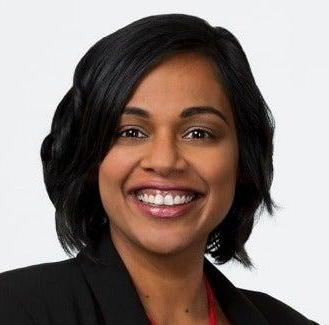

                                                                                                                                                           source_url  \
666  https://www.nzherald.co.nz/nz/politics/climate-change-conference-james-shaw-forced-to-delay-climate-policies-thanks-to-understaffing/E7DILTWNTRGYDL4TE7CONZJKDU/   

                                                                                          image_url  \
666  https://cloudfront-ap-southeast-2.images.arcpublishing.com/nzme/6JHHFRHEZIXP36PHRLO4DUAUPY.jpg   

                    image_path     mp_name   org_name  \
666  NZ Herald__9LIB0R82RP.jpg  James Shaw  NZ Herald   

            cropped_image_path  faces  sentiment_negative  sentiment_neutral  \
666  NZ Herald__9LIB0R82RP.jpg    NaN            0.999931           0.000061   

     sentiment_positive  sentiment  
666            0.000008  -0.999923  


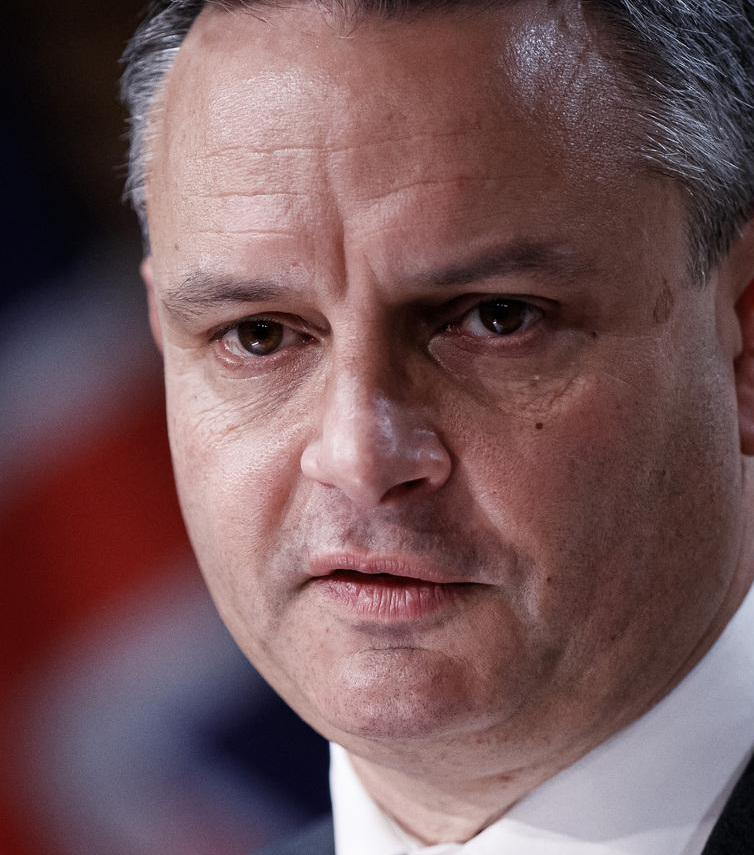

In [91]:
# get row with lowest sentiment

MIN_SENTIMENT = IMAGES_TABLE[IMAGES_TABLE["sentiment"] == IMAGES_TABLE["sentiment"].max()]
MAX_SENTIMENT = IMAGES_TABLE[IMAGES_TABLE["sentiment"] == IMAGES_TABLE["sentiment"].min()]
print(MIN_SENTIMENT)
display( Image.open(f'{CROPPED_IMAGES_DIR}/{MIN_SENTIMENT["cropped_image_path"].values[0]}'))
print(MAX_SENTIMENT)
display( Image.open(f'{CROPPED_IMAGES_DIR}/{MAX_SENTIMENT["cropped_image_path"].values[0]}'))

In [92]:
IMAGES_TABLE.to_csv('sentiment_table.csv', index=False)